In [1]:
import argparse
import numpy as np
import pandas as pd
import os
import sys
import yaml
import torch
import torchmetrics
import matplotlib.pyplot as plt

from argparse import Namespace
from lib import utils
from lib.utils import load_graph_data
from model.att.dcrnn_supervisor import DCRNNSupervisor

In [2]:
def get_supervisor(config_filename, model_path):
    args = Namespace(
        use_cpu_only = False,
        config_filename=config_filename
    )
    
    with open(args.config_filename) as f:
        supervisor_config = yaml.load(f)
        
        graph_pkl_filename = supervisor_config['data'].get('graph_pkl_filename')
        sensor_ids, sensor_id_to_ind, adj_mx = load_graph_data(graph_pkl_filename)
        
        supervisor = DCRNNSupervisor(adj_mx = adj_mx, **supervisor_config)
        supervisor._setup_graph()
        
        checkpoint = torch.load(model_path, map_location='cpu')
        supervisor.dcrnn_model.load_state_dict(checkpoint['model_state_dict'])
        
        return supervisor

In [3]:
def get_prediction_data(supervisor):
    with torch.no_grad():
        supervisor.dcrnn_model = supervisor.dcrnn_model.eval()
        
        val_iterator = supervisor._data['test_loader'].get_iterator()
        y_preds = []
        
        for _, (x, y) in enumerate(val_iterator):
            x, y = supervisor._prepare_data(x, y)
            output = supervisor.dcrnn_model(x)
            y_preds.append(output.cpu())
            
        y_preds = np.concatenate(y_preds, axis=1)
        y_preds_scaled = []
        
        for t in range(y_preds.shape[0]):
            y_pred = supervisor.standard_scaler.inverse_transform(y_preds[t])
            y_preds_scaled.append(y_pred)
            
        return y_preds_scaled

In [4]:
def get_truth_data(supervisor, dataset_dir):
    supervisor._data = utils.load_dataset(dataset_dir = dataset_dir, 
                                          batch_size = 64, 
                                          val_batch_size = 64,
                                          test_batch_size=64)
    supervisor.standard_scaler = supervisor._data['scaler']
    val_iterator = supervisor._data['test_loader'].get_iterator()
    y_truths = []
    
    for _, (x, y) in enumerate(val_iterator):
        x, y = supervisor._prepare_data(x, y)
        y_truths.append(y.cpu())
    y_truths = np.concatenate(y_truths, axis=1)
    y_truth_scaled = []
    
    for t in range(y_truths.shape[0]):
        y_truth = supervisor.standard_scaler.inverse_transform(y_truths[t])
        y_truth_scaled.append(y_truth)
        
    return y_truth_scaled

In [5]:
def evaluation(y_pred, y_true):
    for i in range(4):
        idx = i * 3 + 2
        prediction = y_pred[idx]
        real = y_true[idx]
        print(idx)

        mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(prediction), 
            torch.from_numpy(real)
        )
        rmse = torch.sqrt(
            torchmetrics.functional.mean_squared_error(
                torch.from_numpy(prediction), 
                torch.from_numpy(real)
            )
        )

        mapes = torchmetrics.MeanAbsolutePercentageError()
        mape2 = mapes(preds = torch.from_numpy(prediction), 
                      target = torch.from_numpy(real))
        mape = np.sum(np.abs(real - prediction) / real) / (real.shape[0] * real.shape[1])

        print((idx+1) * 5, 'Min')
        print('MAE:', mae, 'RMSE:', rmse, 'MAPE:', mape * 100, 'MAPE2:', mape2*100)

In [6]:
def missing_eval(y_pred, y_true):
    mae = torchmetrics.functional.mean_absolute_error(
            torch.from_numpy(y_pred),
            torch.from_numpy(y_true)
    )
    rmse = torch.sqrt(
        torchmetrics.functional.mean_squared_error(
            torch.from_numpy(y_pred),
            torch.from_numpy(y_true)
        )
    )
    
    mapes = torchmetrics.MeanAbsolutePercentageError()
    mape = mapes(preds = torch.from_numpy(y_pred), target = torch.from_numpy(y_true))
    
    return mae.item(), rmse.item(), mape.item()

In [7]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [8]:
df = pd.read_csv('../Missing Data/0per_feature.csv').drop(columns=['Unnamed: 0'])
df

,1220027200,1220028300,1220026200,1220029700,1220028200,1220029100,1220027400,1220029900,1220029000,1220030100,...,007002,007003,008000,008001,008002,008003,009000,009001,009002,009003
0,26.81,21.90,30.22,25.19,20.30,28.65,30.79,28.18,26.37,19.00,...,28.805,29.395,28.275,26.445,30.905,29.075,21.655,28.105,27.120,33.570
1,29.64,19.84,27.00,26.96,20.49,31.06,30.52,31.57,22.31,24.67,...,25.410,29.355,33.770,30.400,34.810,31.440,27.750,24.750,35.750,32.750
2,28.94,20.95,32.49,26.20,22.35,31.83,27.82,31.39,19.00,23.85,...,25.210,27.875,31.320,29.335,30.640,28.655,27.070,27.905,27.720,28.555
3,28.41,20.36,30.44,26.72,24.68,29.19,32.74,29.39,24.60,27.85,...,27.100,28.180,31.750,27.220,34.080,29.550,25.700,25.225,29.100,28.625
4,30.29,20.47,30.82,27.21,19.57,33.13,29.08,27.15,23.87,26.02,...,20.920,26.090,28.510,29.510,31.365,32.365,20.955,28.455,24.395,31.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,25.78,23.89,33.47,25.93,15.57,23.16,21.88,37.42,24.97,22.07,...,25.865,32.045,25.620,24.880,33.115,32.375,26.260,30.175,29.785,33.700
2876,27.20,23.04,33.22,28.45,14.22,25.27,23.90,36.46,24.42,20.99,...,26.540,27.590,26.015,21.405,30.585,25.975,27.840,26.730,28.390,27.280
2877,26.61,26.83,33.90,25.24,14.31,23.24,24.18,34.65,26.05,21.49,...,31.715,30.045,24.870,24.240,32.620,31.990,23.980,19.500,31.240,26.760
2878,27.83,28.97,31.51,28.05,14.21,26.31,25.17,32.84,25.08,21.82,...,29.170,30.095,32.400,29.190,35.075,31.865,28.120,28.950,31.120,31.950


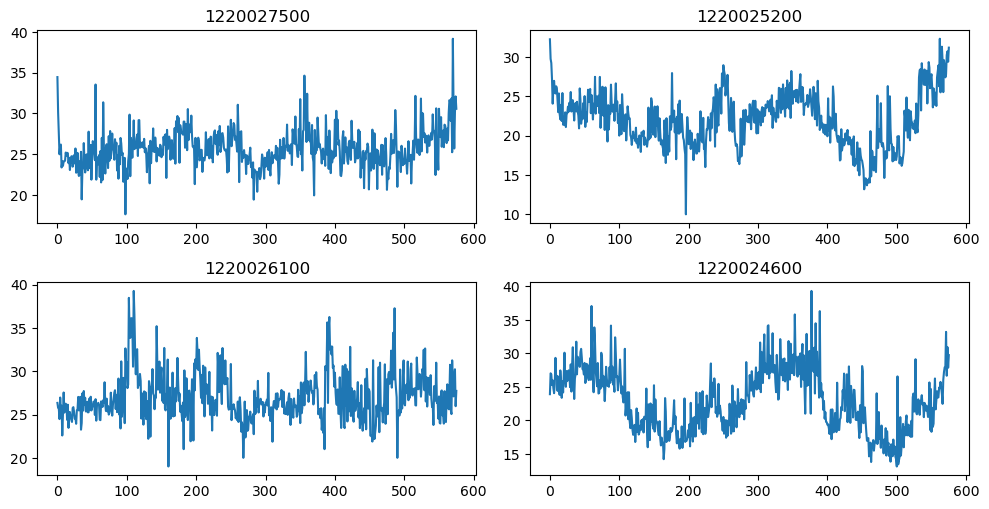

In [9]:
plt.figure(figsize=(10,10))

plt.subplot(4, 2, 1)
plt.title('1220027500')
plt.plot(df['1220027500'].values[-576:])

plt.subplot(4, 2, 2)
plt.title('1220025200')
plt.plot(df['1220025200'].values[-576:])

plt.subplot(4, 2, 3)
plt.title('1220026100')
plt.plot(df['1220026100'].values[-576:])

plt.subplot(4, 2, 4)
plt.title('1220024600')
plt.plot(df['1220024600'].values[-576:])

plt.tight_layout()

### 0%

In [11]:
supervisor = get_supervisor('data/yamls/0per_int.yaml', 'models/0per_int/epo26.tar')
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/0per_int')
evaluation(y_pred, y_true)

2023-08-22 02:14:48,348 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0822021448/
2023-08-22 02:14:48,348 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0822021448/
2023-08-22 02:14:48,424 - INFO - Model created
2023-08-22 02:14:48,424 - INFO - Model created


C:\Users\USER\AppData\Local\Temp\ipykernel_97348\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


2
15 Min
MAE: tensor(1.9762) RMSE: tensor(2.8616) MAPE: 8.475524407845956 MAPE2: tensor(8.4755)
5
30 Min
MAE: tensor(2.2712) RMSE: tensor(3.1695) MAPE: 9.74961151311427 MAPE2: tensor(9.7496)
8
45 Min
MAE: tensor(2.5437) RMSE: tensor(3.4687) MAPE: 10.881665312213663 MAPE2: tensor(10.8817)
11
60 Min
MAE: tensor(2.8108) RMSE: tensor(3.7584) MAPE: 12.005756519458911 MAPE2: tensor(12.0058)


In [12]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(y_pred[i][:36])
    y_truth.append(y_true[i][:36])
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(1.7246) RMSE: tensor(2.3974) MAPE: 6.63697749008367 MAPE2: tensor(6.6370)
5
30 Min
MAE: tensor(1.9939) RMSE: tensor(2.7373) MAPE: 7.547317316502701 MAPE2: tensor(7.5473)
8
45 Min
MAE: tensor(2.2807) RMSE: tensor(3.1097) MAPE: 8.58742160561644 MAPE2: tensor(8.5874)
11
60 Min
MAE: tensor(2.4851) RMSE: tensor(3.3560) MAPE: 9.269854463176962 MAPE2: tensor(9.2699)


### 5%

In [13]:
supervisor = get_supervisor('data/yamls/5per_int.yaml', 'models/5per_int/epo28.tar')
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/5per_int')
evaluation(y_pred, y_true)

2023-08-22 02:14:54,215 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0822021454/
2023-08-22 02:14:54,215 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0822021454/
2023-08-22 02:14:54,215 - INFO - Log directory: data/model\dcrnn_DR_2_h_12_64-64_lr_0.01_bs_64_0822021454/
2023-08-22 02:14:54,290 - INFO - Model created
2023-08-22 02:14:54,290 - INFO - Model created
2023-08-22 02:14:54,290 - INFO - Model created


C:\Users\USER\AppData\Local\Temp\ipykernel_97348\1902753131.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  supervisor_config = yaml.load(f)


2
15 Min
MAE: tensor(2.1913) RMSE: tensor(3.2351) MAPE: 9.198263579723882 MAPE2: tensor(9.1983)
5
30 Min
MAE: tensor(2.5360) RMSE: tensor(3.5915) MAPE: 10.71212868285335 MAPE2: tensor(10.7121)
8
45 Min
MAE: tensor(2.8368) RMSE: tensor(3.9255) MAPE: 11.943984187506382 MAPE2: tensor(11.9440)
11
60 Min
MAE: tensor(3.1147) RMSE: tensor(4.2279) MAPE: 13.04217195199206 MAPE2: tensor(13.0422)


In [14]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(y_pred[i][:32])
    y_truth.append(y_true[i][:32])
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(1.9114) RMSE: tensor(2.6708) MAPE: 7.2175418629365815 MAPE2: tensor(7.2175)
5
30 Min
MAE: tensor(2.3025) RMSE: tensor(3.1290) MAPE: 8.644113119910745 MAPE2: tensor(8.6441)
8
45 Min
MAE: tensor(2.5712) RMSE: tensor(3.4828) MAPE: 9.468949542326085 MAPE2: tensor(9.4689)
11
60 Min
MAE: tensor(2.8619) RMSE: tensor(3.8458) MAPE: 10.455679893493652 MAPE2: tensor(10.4557)


In [15]:
for i in range(12):
    y_pred[i] = np.concatenate((y_pred[i], np.zeros((576, 4))), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220027500'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220025200'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220026100'].values[-576:].reshape(-1, 1)), axis=1)
    y_true[i] = np.concatenate((y_true[i], df['1220024600'].values[-576:].reshape(-1, 1)), axis=1)
    
evaluation(y_pred, y_true)

2
15 Min
MAE: tensor(3.4262, dtype=torch.float64) RMSE: tensor(6.6236, dtype=torch.float64) MAPE: 14.24280426501986 MAPE2: tensor(14.2428)
5
30 Min
MAE: tensor(3.7517, dtype=torch.float64) RMSE: tensor(6.7948, dtype=torch.float64) MAPE: 15.672566538879925 MAPE2: tensor(15.6726)
8
45 Min
MAE: tensor(4.0358, dtype=torch.float64) RMSE: tensor(6.9671, dtype=torch.float64) MAPE: 16.835984504990332 MAPE2: tensor(16.8360)
11
60 Min
MAE: tensor(4.2982, dtype=torch.float64) RMSE: tensor(7.1323, dtype=torch.float64) MAPE: 17.873163558700913 MAPE2: tensor(17.8732)


In [16]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i][:32], y_pred[i][-4].reshape(1, -1)), axis=0))
    y_truth.append(np.concatenate((y_true[i][:32], y_true[i][-4].reshape(1, -1)), axis=0))
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(3.2109, dtype=torch.float64) RMSE: tensor(6.5193, dtype=torch.float64) MAPE: 12.381820264305885 MAPE2: tensor(12.3818)
5
30 Min
MAE: tensor(3.5698, dtype=torch.float64) RMSE: tensor(6.6978, dtype=torch.float64) MAPE: 13.690725901586834 MAPE2: tensor(13.6907)
8
45 Min
MAE: tensor(3.8314, dtype=torch.float64) RMSE: tensor(6.8643, dtype=torch.float64) MAPE: 14.506413274535838 MAPE2: tensor(14.5064)
11
60 Min
MAE: tensor(4.1088, dtype=torch.float64) RMSE: tensor(7.0449, dtype=torch.float64) MAPE: 15.436974120455002 MAPE2: tensor(15.4370)


In [17]:
drop_df = pd.read_csv('../Missing Intersection/5per_int_feature.csv').drop(columns = ['Unnamed: 0'])
drop_df

,1220027200,1220028300,1220026200,1220029700,1220028200,1220029100,1220027400,1220029900,1220029000,1220030100,...,007002,007003,008000,008001,008002,008003,009000,009001,009002,009003
0,26.81,21.90,30.22,25.19,20.30,28.65,30.79,28.18,26.37,19.00,...,28.805,29.395,28.275,26.445,30.905,29.075,21.655,28.105,27.120,33.570
1,29.64,19.84,27.00,26.96,20.49,31.06,30.52,31.57,22.31,24.67,...,25.410,29.355,33.770,30.400,34.810,31.440,27.750,24.750,35.750,32.750
2,28.94,20.95,32.49,26.20,22.35,31.83,27.82,31.39,19.00,23.85,...,25.210,27.875,31.320,29.335,30.640,28.655,27.070,27.905,27.720,28.555
3,28.41,20.36,30.44,26.72,24.68,29.19,32.74,29.39,24.60,27.85,...,27.100,28.180,31.750,27.220,34.080,29.550,25.700,25.225,29.100,28.625
4,30.29,20.47,30.82,27.21,19.57,33.13,29.08,27.15,23.87,26.02,...,20.920,26.090,28.510,29.510,31.365,32.365,20.955,28.455,24.395,31.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,25.78,23.89,33.47,25.93,15.57,23.16,21.88,37.42,24.97,22.07,...,25.865,32.045,25.620,24.880,33.115,32.375,26.260,30.175,29.785,33.700
2876,27.20,23.04,33.22,28.45,14.22,25.27,23.90,36.46,24.42,20.99,...,26.540,27.590,26.015,21.405,30.585,25.975,27.840,26.730,28.390,27.280
2877,26.61,26.83,33.90,25.24,14.31,23.24,24.18,34.65,26.05,21.49,...,31.715,30.045,24.870,24.240,32.620,31.990,23.980,19.500,31.240,26.760
2878,27.83,28.97,31.51,28.05,14.21,26.31,25.17,32.84,25.08,21.82,...,29.170,30.095,32.400,29.190,35.075,31.865,28.120,28.950,31.120,31.950


In [18]:
y_pred = get_prediction_data(supervisor)
y_true = get_truth_data(supervisor, 'data/5per_int')

In [19]:
print(np.where(drop_df.columns == '005000'), np.where(drop_df.columns == '005001'))
print(np.where(drop_df.columns == '005002'), np.where(drop_df.columns == '005003'))

(array([48], dtype=int64),) (array([49], dtype=int64),)
(array([50], dtype=int64),) (array([51], dtype=int64),)


In [20]:
print(np.where(df.columns == '1220027500'), np.where(df.columns == '1220025200'))
print(np.where(df.columns == '1220026100'), np.where(df.columns == '1220024600'))

(array([19], dtype=int64),) (array([16], dtype=int64),)
(array([17], dtype=int64),) (array([18], dtype=int64),)


In [25]:
y_preds = []
y_truth = []

for i in range(12):
    y_preds.append(np.concatenate((y_pred[i], 
                       (y_pred[i][:, 48].reshape(-1, 1)),
                       (y_pred[i][:, 49].reshape(-1, 1)),
                       (y_pred[i][:, 50].reshape(-1, 1)),
                       (y_pred[i][:, 51].reshape(-1, 1))), axis=1))
    
    y_truth.append(np.concatenate((y_true[i], 
                        df['1220027500'].values[-576:].reshape(-1, 1),
                        df['1220025200'].values[-576:].reshape(-1, 1),
                        df['1220026100'].values[-576:].reshape(-1, 1),
                        df['1220024600'].values[-576:].reshape(-1, 1)), axis=1))
    
evaluation(y_preds, y_truth)

for i in range(12):
    y_preds[i] = y_preds[i][:, :36]
    y_truth[i] = y_truth[i][:, :36]
    
evaluation(y_preds, y_truth)

2
15 Min
MAE: tensor(2.9386, dtype=torch.float64) RMSE: tensor(6.6061, dtype=torch.float64) MAPE: 12.532320887155876 MAPE2: tensor(12.5323)
5
30 Min
MAE: tensor(3.2603, dtype=torch.float64) RMSE: tensor(6.7645, dtype=torch.float64) MAPE: 13.952402703009781 MAPE2: tensor(13.9524)
8
45 Min
MAE: tensor(3.5333, dtype=torch.float64) RMSE: tensor(6.8931, dtype=torch.float64) MAPE: 15.069694092943662 MAPE2: tensor(15.0697)
11
60 Min
MAE: tensor(3.7869, dtype=torch.float64) RMSE: tensor(7.0329, dtype=torch.float64) MAPE: 16.066344310442485 MAPE2: tensor(16.0663)
2
15 Min
MAE: tensor(2.3063, dtype=torch.float64) RMSE: tensor(3.3769, dtype=torch.float64) MAPE: 10.149906016261308 MAPE2: tensor(10.1499)
5
30 Min
MAE: tensor(2.6337, dtype=torch.float64) RMSE: tensor(3.6961, dtype=torch.float64) MAPE: 11.641508212476834 MAPE2: tensor(11.6415)
8
45 Min
MAE: tensor(2.8974, dtype=torch.float64) RMSE: tensor(3.9808, dtype=torch.float64) MAPE: 12.742227423687643 MAPE2: tensor(12.7422)
11
60 Min
MAE: tens

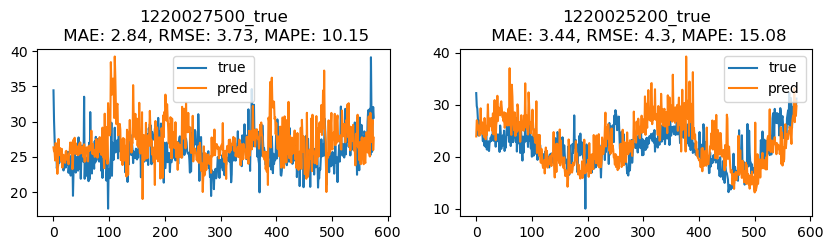

15
3.1362673611111114 4.0152003961852625 0.12614761292934418


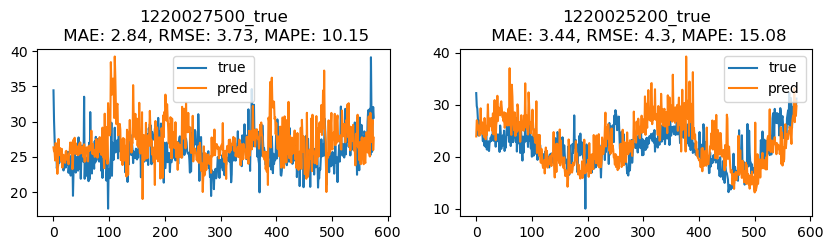

30
3.1362673611111114 4.0152003961852625 0.12614761292934418


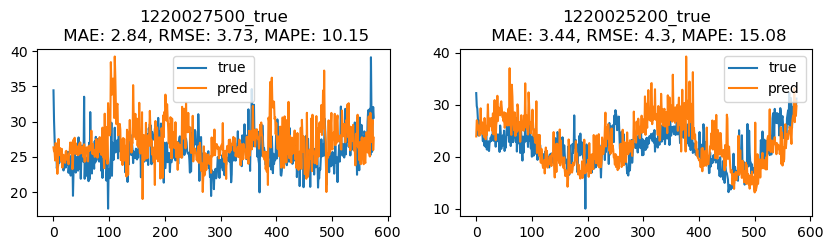

45
3.1362673611111114 4.0152003961852625 0.12614761292934418


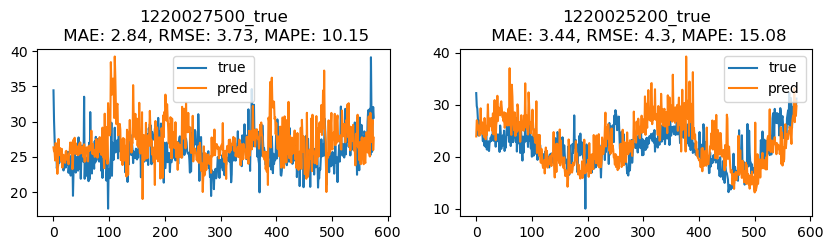

60
3.1362673611111114 4.0152003961852625 0.12614761292934418


In [26]:
for idx in range(4):

    sim_df = pd.DataFrame(columns=['1220027500_true', '1220025200_true',
                                   '1220026100_true', '1220024600_true',
                                   '1220027500_pred', '1220025200_pred',
                                   '1220026100_pred', '1220024600_pred'])

    sim_df['1220027500_true'] = df['1220027500'].values[-576:]
    sim_df['1220025200_true'] = df['1220025200'].values[-576:]
    sim_df['1220026100_true'] = df['1220026100'].values[-576:]
    sim_df['1220024600_true'] = df['1220024600'].values[-576:]

    sim_df['1220027500_pred'] = y_pred[idx*3+2][:, 48]
    sim_df['1220025200_pred'] = y_pred[idx*3+2][:, 49]
    sim_df['1220026100_pred'] = y_pred[idx*3+2][:, 50]
    sim_df['1220024600_pred'] = y_pred[idx*3+2][:, 51]

    maes = []
    rmses = []
    mapes = []

    plt.figure(figsize=(10,10))

    for i in range(2):
        plt.subplot(4, 2, i+1)
        columns = sim_df.columns
        mae, rmse, mape = missing_eval(sim_df[columns[i]].values, sim_df[columns[i+2]].values)
        plt.title(columns[i] + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                             ', MAPE: ' + str(round(mape * 100, 2)))
        plt.plot(sim_df[columns[i]].values, label='true')
        plt.plot(sim_df[columns[i+2]].values, label='pred')
        plt.legend()

        maes.append(mae)
        rmses.append(rmse)
        mapes.append(mape)

    plt.show()
    
    print((idx+1)*15)
    print(np.mean(np.array(maes)), np.mean(np.array(rmses)), np.mean(np.array(mapes)))

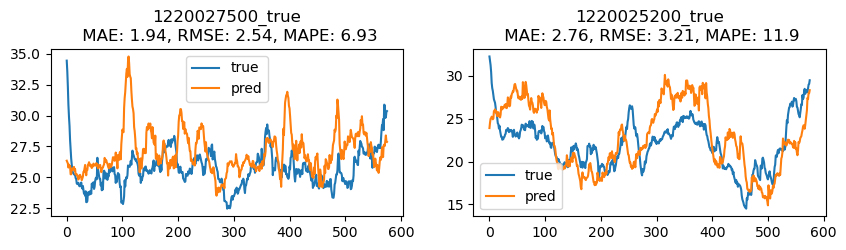

15
2.347179949878386 2.8727227761953915 0.09416550397872925


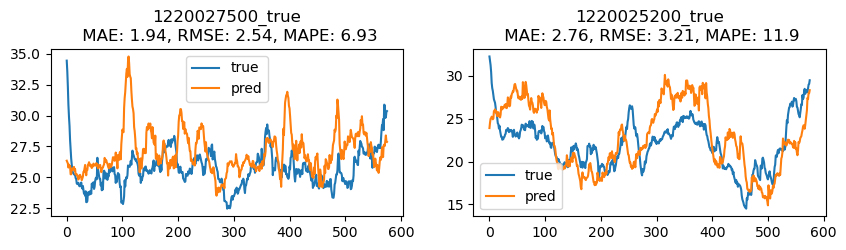

30
2.347179949878386 2.8727227761953915 0.09416550397872925


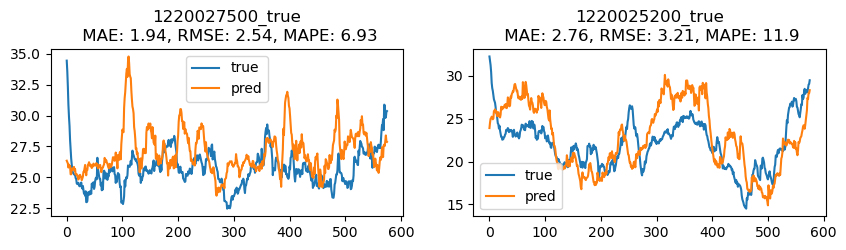

45
2.347179949878386 2.8727227761953915 0.09416550397872925


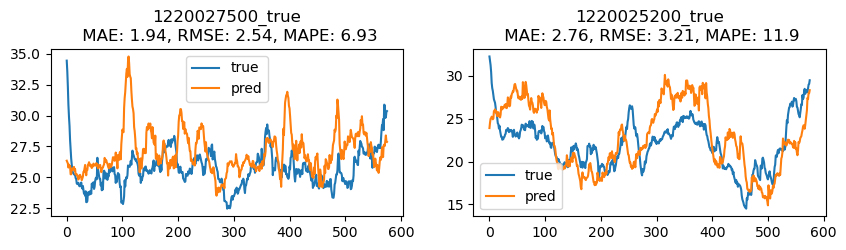

60
2.347179949878386 2.8727227761953915 0.09416550397872925


In [27]:
for idx in range(4):

    sim_df = pd.DataFrame(columns=['1220027500_true', '1220025200_true',
                                   '1220026100_true', '1220024600_true',
                                   '1220027500_pred', '1220025200_pred',
                                   '1220026100_pred', '1220024600_pred'])

    sim_df['1220027500_true'] = smooth(df['1220027500'].values[-576:], 0.8)
    sim_df['1220025200_true'] = smooth(df['1220025200'].values[-576:], 0.8)
    sim_df['1220026100_true'] = smooth(df['1220026100'].values[-576:], 0.8)
    sim_df['1220024600_true'] = smooth(df['1220024600'].values[-576:], 0.8)

    sim_df['1220027500_pred'] = smooth(y_pred[idx*3+2][:, 48], 0.5)
    sim_df['1220025200_pred'] = smooth(y_pred[idx*3+2][:, 49], 0.5)
    sim_df['1220026100_pred'] = smooth(y_pred[idx*3+2][:, 50], 0.5)
    sim_df['1220024600_pred'] = smooth(y_pred[idx*3+2][:, 51], 0.5)

    maes = []
    rmses = []
    mapes = []

    plt.figure(figsize=(10,10))

    for i in range(2):
        plt.subplot(4, 2, i+1)
        columns = sim_df.columns
        mae, rmse, mape = missing_eval(sim_df[columns[i]].values, sim_df[columns[i+2]].values)
        plt.title(columns[i] + '\n MAE: ' + str(round(mae, 2)) + ', RMSE: ' + str(round(rmse, 2)) + 
                                             ', MAPE: ' + str(round(mape * 100, 2)))
        plt.plot(sim_df[columns[i]].values, label='true')
        plt.plot(sim_df[columns[i+2]].values, label='pred')
        plt.legend()

        maes.append(mae)
        rmses.append(rmse)
        mapes.append(mape)

    plt.show()
    
    print((idx+1)*15)
    print(np.mean(np.array(maes)), np.mean(np.array(rmses)), np.mean(np.array(mapes)))